In [ ]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

random_state = 42

In [6]:
# read (X_train, y_train) and (X_test, y_test) to csv file
train_file = 'train_data.csv'
test_file = 'test_data.csv'

training_worksheet = pd.read_csv(train_file)
test_worksheet = pd.read_csv(test_file)

print("Training data shape:", training_worksheet.shape)
print("Test data shape:", test_worksheet.shape)
training_worksheet.head()

Training data shape: (6336, 14)
Test data shape: (1314, 14)


,monomer,log_r,mol1_HOMO_1,mol1_HOMO,mol1_LUMO,mol1_LUMO_Add1,mol2_HOMO_1,mol2_HOMO,mol2_LUMO,mol2_LUMO_Add1,rad1_HOMO_1,rad1_HOMO,rad1_LUMO,rad1_LUMO_Add1
0,"Oxazoline, 2-, 2-isopropenyl-.Styrene",0.640,-0.228400,-0.200261,-0.062436,0.026590,-0.230012,-0.203579,-0.064886,-0.034535,-0.204315,-0.160277,-0.110536,0.023523
1,"Oxazoline, 2-, 2-isopropenyl-.Styrene",0.680,-0.228400,-0.200261,-0.062436,0.026590,-0.230012,-0.203579,-0.064886,-0.034535,-0.204315,-0.160277,-0.110536,0.023523
2,Acrylonitrile.Vinyltrimethylsilane,4.080,-0.307886,-0.266671,-0.092915,-0.013216,-0.255616,-0.233763,-0.037205,0.022599,-0.292009,-0.205459,-0.146590,-0.015383
3,Acrylonitrile.Vinyltrimethylsilane,4.080,-0.307886,-0.266671,-0.092915,-0.013216,-0.255616,-0.233763,-0.037205,0.022599,-0.292009,-0.205459,-0.146590,-0.015383
4,"Citraconate, dibenzyl.Styrene",0.047,-0.221966,-0.219152,-0.079531,-0.043276,-0.230012,-0.203579,-0.064886,-0.034535,-0.215363,-0.184527,-0.137820,-0.044014


In [7]:
X_train, y_train = training_worksheet.iloc[:, 2:], training_worksheet.iloc[:, 1]
X_test, y_test = test_worksheet.iloc[:, 2:], test_worksheet.iloc[:, 1]

print("Training data shapes:", X_train.shape, y_train.shape)
print("Test data shapes:", X_test.shape, y_test.shape)

Training data shapes: (6336, 12) (6336,)
Test data shapes: (1314, 12) (1314,)


In [8]:
# Preprocessing x and y
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = X_train_scaled
X_test = X_test_scaled

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)


In [9]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


best_params = {'colsample_bytree': 0.9,
  'gamma': 0.1,
  'learning_rate': 0.1,
  'max_depth': 10,
  'min_child_weight': 1,
  'n_estimators': 200,
  'reg_alpha': 0,
  'reg_lambda': 2,
  'subsample': 0.9}



print("\nBest Hyperparameters:", best_params)
best_xgb_model = XGBRegressor(
    random_state=random_state,
    objective='reg:squarederror',
    eval_metric='rmse',
    n_jobs=-1,
    **best_params
)

best_xgb_model.fit(X_train, y_train_log)


Best Hyperparameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.9}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [10]:
y_train_log_pred = best_xgb_model.predict(X_train)
y_test_log_pred  = best_xgb_model.predict(X_test)

In [11]:
# Compute evaluation metrics
train_log_mse = mean_squared_error(y_train_log, y_train_log_pred)
test_log_mse  = mean_squared_error(y_test_log, y_test_log_pred)

train_log_rmse = np.sqrt(train_log_mse)
test_log_rmse  = np.sqrt(test_log_mse)

train_log_mae = mean_absolute_error(y_train_log, y_train_log_pred)
test_log_mae  = mean_absolute_error(y_test_log, y_test_log_pred)

train_log_r2 = r2_score(y_train_log, y_train_log_pred)
test_log_r2  = r2_score(y_test_log, y_test_log_pred)

# Print evaluation results
print(f"\nTrain MSE: {train_log_mse:.4f}")
print(f"Test MSE:  {test_log_mse:.4f}")
print(f"\nTrain RMSE: {train_log_rmse:.4f}")
print(f"Test RMSE:  {test_log_rmse:.4f}")
print(f"\nTrain MAE: {train_log_mae:.4f}")
print(f"Test MAE:  {test_log_mae:.4f}")
print(f"\nTrain R²: {train_log_r2:.4f}")
print(f"Test R²:  {test_log_r2:.4f}")



Train MSE: 0.2103
Test MSE:  1.4304

Train RMSE: 0.4586
Test RMSE:  1.1960

Train MAE: 0.2577
Test MAE:  0.8158

Train R²: 0.9174
Test R²:  0.5059


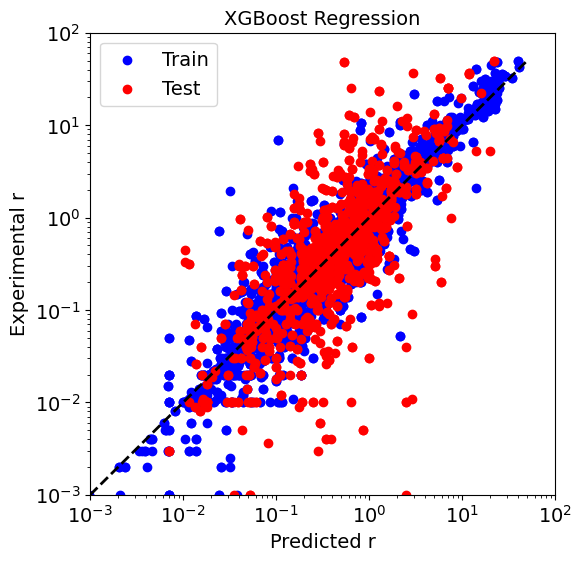

In [27]:
# plot results
plt.figure(figsize=(6, 6))
plt.scatter(np.exp(y_train_log_pred),y_train,  color='blue', label='Train')
plt.scatter(np.exp(y_test_log_pred),y_test,  color='red', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.ylabel('Experimental r', fontsize=14)
plt.xlabel('Predicted r', fontsize=14)
plt.xlim(1E-3, 100)
plt.ylim(1E-3, 100)
plt.xscale('log')
plt.yscale('log')

# adjust axis font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('XGBoost Regression', fontsize=14)
plt.legend(fontsize=14)
plt.show()


In [ ]:
import shap

# Initialize the SHAP TreeExplainer with your trained model
explainer = shap.TreeExplainer(best_xgb_model)

# Compute SHAP values for your training data
shap_values = explainer.shap_values(X_test)

feature_names = test_worksheet.columns[2:]

/Users/jingdan/miniconda3/envs/my-rdkit-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


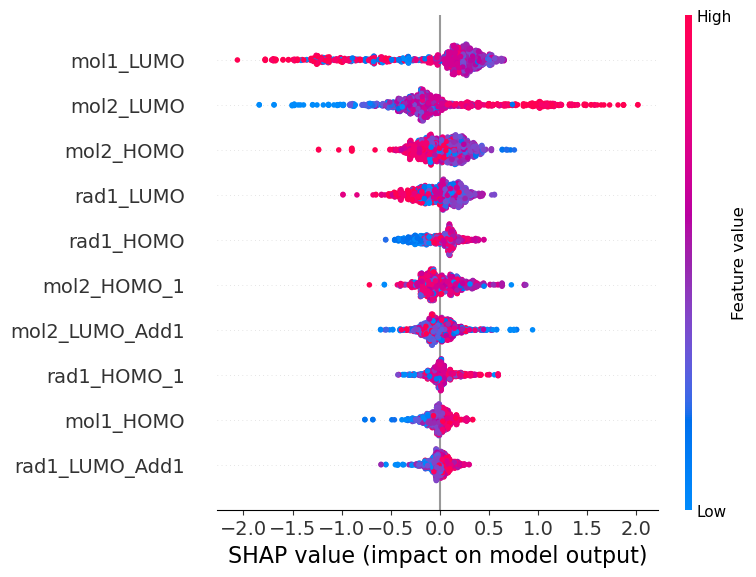

In [14]:
# Set matplotlib parameters for larger fonts
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})  # Increase base font size

# Create the SHAP summary plot with increased font sizes
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=feature_names, 
    max_display=10,
    plot_size=(8, 6),  # Larger figure size to accommodate larger text
    # title_fontsize=16,  # Title font size
    show=False  # Don't show the plot yet so we can modify it
)


# Get the current figure and adjust font sizes
plt.xlabel('SHAP value (impact on model output)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adjust legend if present
legend = plt.gca().get_legend()
if legend is not None:
    for text in legend.get_texts():
        text.set_fontsize(16)

plt.tight_layout()
plt.show()

In [15]:
shap_FMO_interaction_values = explainer.shap_interaction_values(X_test)

<Figure size 1200x1000 with 0 Axes>

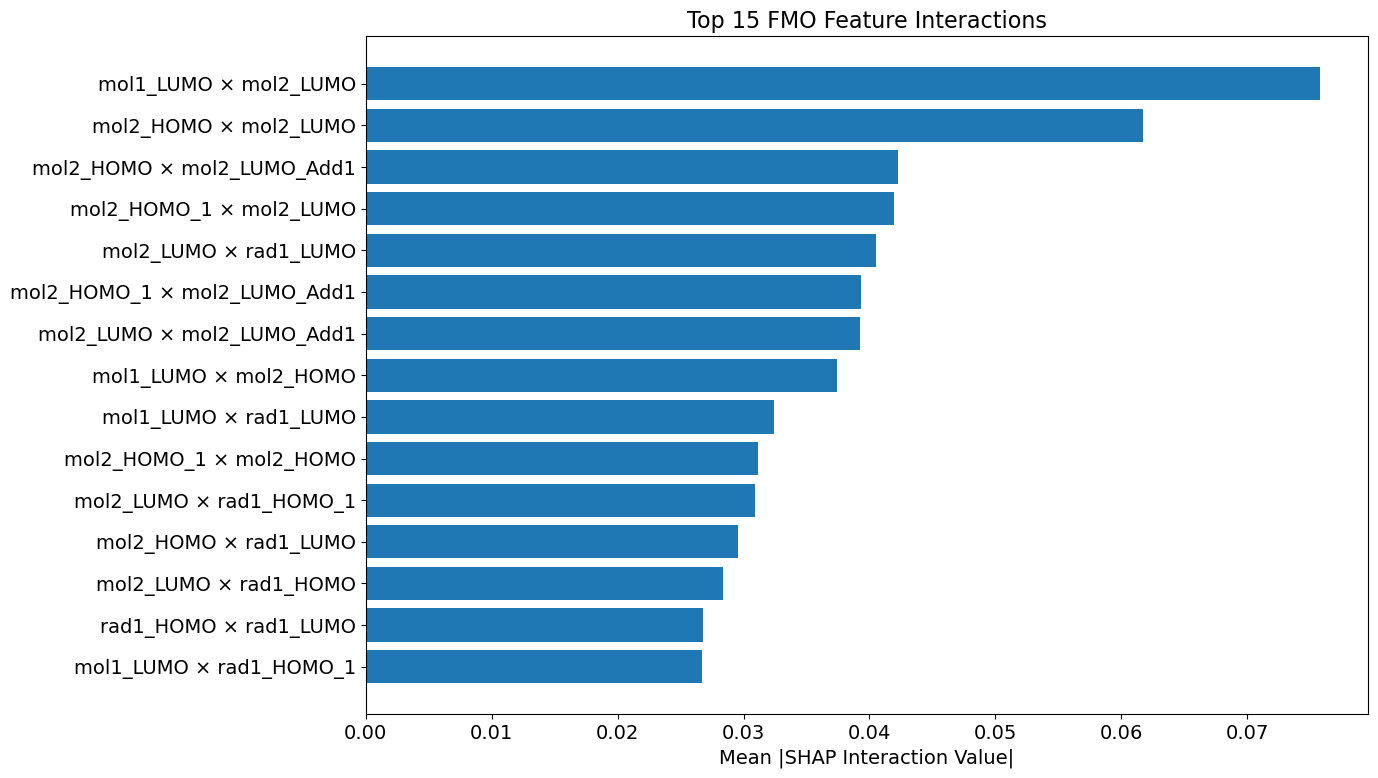

In [16]:
FMO_feature_names = list(feature_names)
FMO_interactions = np.zeros((len(FMO_feature_names), len(FMO_feature_names)))

# Fill the interaction matrix with the mean absolute SHAP interaction values
for i in range(len(FMO_feature_names)):
    for j in range(len(FMO_feature_names)):
        FMO_interactions[i, j] = np.abs(shap_FMO_interaction_values[:, i, j]).mean()

# Create a heatmap of the interactions
plt.figure(figsize=(12, 10))
mask = np.zeros_like(FMO_interactions, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask the upper triangle to avoid redundancy

# Optional: Create a bar plot of the most important FMO feature interactions
interaction_importance = []
for i in range(len(FMO_feature_names)):
    for j in range(i+1, len(FMO_feature_names)):
        interaction_importance.append((
            f"{FMO_feature_names[i]} × {FMO_feature_names[j]}",
            np.abs(shap_FMO_interaction_values[:, i, j]).mean()
        ))

# Sort by importance and plot top 15
interaction_importance.sort(key=lambda x: x[1], reverse=True)
top_n = 15
top_interactions = interaction_importance[:top_n]

plt.figure(figsize=(14, 8))
plt.barh([x[0] for x in top_interactions], [x[1] for x in top_interactions])
plt.xlabel('Mean |SHAP Interaction Value|')
plt.title(f'Top {top_n} FMO Feature Interactions', fontsize=16)
plt.gca().invert_yaxis()  # To have the highest value at the top
plt.tight_layout()
plt.show()

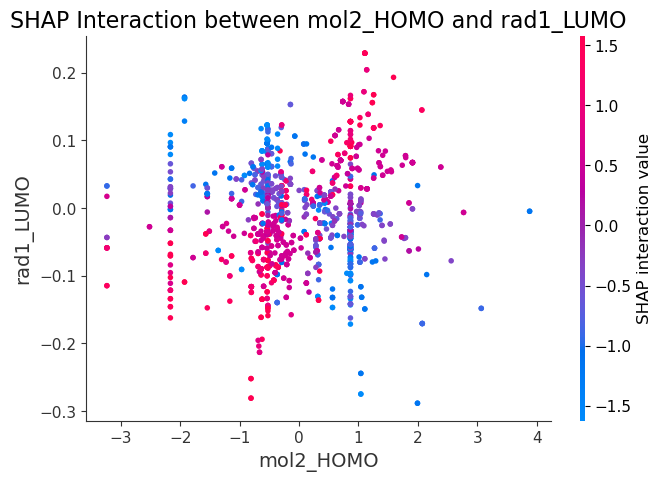

In [17]:
# Identify the indices for mol1_LUMO and mol2_LUMO features
feature1 = "mol2_HOMO"
feature2 = "rad1_LUMO"

idx1 = FMO_feature_names.index(feature1)
idx2 = FMO_feature_names.index(feature2)

# Create the dependence plot for interaction effects
shap.dependence_plot(
    (idx1, idx2),  # Tuple of feature indices for interaction - swapped order
    shap_FMO_interaction_values,     # The interaction values you calculated
    X_test,                          # Feature matrix
    display_features=X_test,         # Features to display (usually same as features)
    feature_names=FMO_feature_names,      # Feature names
    show=False  # Don't show immediately so we can add title
)

# Fixing a bug: Switch the y-axis and color bar labels
plt.ylabel(feature2, fontsize=14)  
plt.xlabel(feature1, fontsize=14)  
cbar = plt.gcf().axes[-1]  # Get the colorbar
cbar.set_ylabel(f'SHAP interaction value', fontsize=12)  

# Set the title for the plot and show it
plt.title(f'SHAP Interaction between {feature1} and {feature2}', fontsize=16)
plt.show()


Explaining prediction for test instance 0:
Actual y_test[0]: 0.0400
Predicted y_test[0]: 0.0476
Base (expected) value: 0.4434


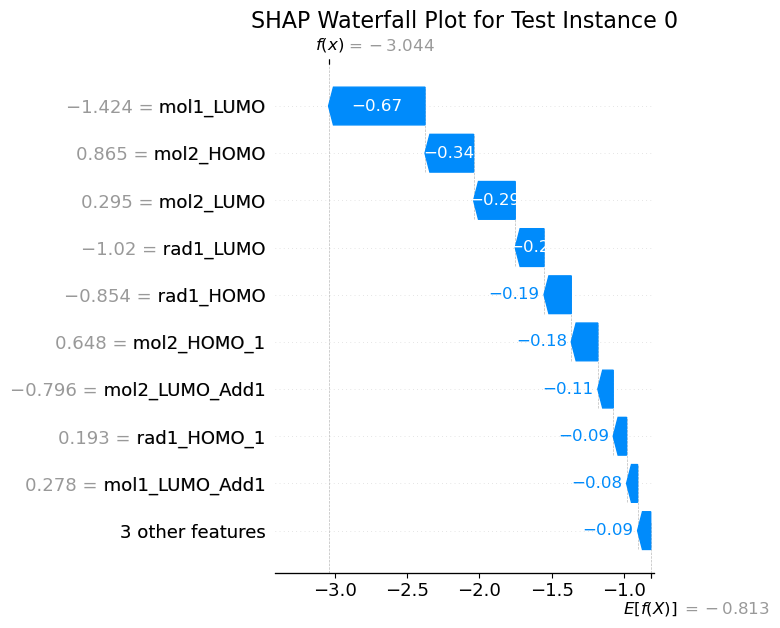


Top 10 most important features for test instance 0:
Feature Name | SHAP Value | Feature Value
--------------------------------------------------
mol1_LUMO                 |  -0.6677 |  -1.4236
mol2_HOMO                 |  -0.3365 |   0.8648
mol2_LUMO                 |  -0.2883 |   0.2947
rad1_LUMO                 |  -0.1993 |  -1.0201
rad1_HOMO                 |  -0.1887 |  -0.8542
mol2_HOMO_1               |  -0.1838 |   0.6480
mol2_LUMO_Add1            |  -0.1067 |  -0.7960
rad1_HOMO_1               |  -0.0926 |   0.1930
mol1_LUMO_Add1            |  -0.0762 |   0.2780
mol1_HOMO_1               |  -0.0455 |   0.3528


In [23]:
# use shap value to explain the features in X_test[0] to y_test[0]

# Get SHAP values for the first test instance
instance_idx = 0
shap_values_instance = shap_values[instance_idx]
X_test_instance = X_test[instance_idx]

print(f"Explaining prediction for test instance {instance_idx}:")
print(f"Actual y_test[{instance_idx}]: {y_test.iloc[instance_idx]:.4f}")
print(f"Predicted y_test[{instance_idx}]: {np.exp(y_test_log_pred[instance_idx]):.4f}")
print(f"Base (expected) value: {np.exp(explainer.expected_value):.4f}")

# Create a waterfall plot to show how each feature contributes to the prediction
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_instance,
        base_values=explainer.expected_value,
        data=X_test_instance,
        feature_names=feature_names
    ),
    max_display=10,
    show=False
)
plt.title(f'SHAP Waterfall Plot for Test Instance {instance_idx}', fontsize=16)
plt.tight_layout()
plt.show()

# Show the top 10 most important features for this instance
feature_importance = list(zip(feature_names, shap_values_instance, X_test_instance))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\nTop 10 most important features for test instance {instance_idx}:")
print("Feature Name | SHAP Value | Feature Value")
print("-" * 50)
for i, (feat_name, shap_val, feat_val) in enumerate(feature_importance[:10]):
    print(f"{feat_name:<25} | {shap_val:>8.4f} | {feat_val:>8.4f}")